In [1]:

import os
import math
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

from osgeo import gdal


2023-03-08 23:37:42.205901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 23:37:42.205982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
batch_size = 6 
crop_size = 512
upscale_factor = 2
input_size = crop_size // upscale_factor


In [3]:
root_dir = "/media/quothbonney/SRTM/512"

In [14]:
files = [root_dir + "/" + fname for fname in os.listdir(root_dir)]

In [15]:
files

['/media/quothbonney/SRTM/512/0.tif',
 '/media/quothbonney/SRTM/512/1.tif',
 '/media/quothbonney/SRTM/512/2.tif',
 '/media/quothbonney/SRTM/512/3.tif',
 '/media/quothbonney/SRTM/512/4.tif',
 '/media/quothbonney/SRTM/512/5.tif',
 '/media/quothbonney/SRTM/512/6.tif',
 '/media/quothbonney/SRTM/512/7.tif',
 '/media/quothbonney/SRTM/512/8.tif',
 '/media/quothbonney/SRTM/512/9.tif',
 '/media/quothbonney/SRTM/512/10.tif',
 '/media/quothbonney/SRTM/512/11.tif',
 '/media/quothbonney/SRTM/512/12.tif',
 '/media/quothbonney/SRTM/512/13.tif',
 '/media/quothbonney/SRTM/512/14.tif',
 '/media/quothbonney/SRTM/512/15.tif',
 '/media/quothbonney/SRTM/512/16.tif',
 '/media/quothbonney/SRTM/512/17.tif',
 '/media/quothbonney/SRTM/512/18.tif',
 '/media/quothbonney/SRTM/512/19.tif',
 '/media/quothbonney/SRTM/512/20.tif',
 '/media/quothbonney/SRTM/512/21.tif',
 '/media/quothbonney/SRTM/512/22.tif',
 '/media/quothbonney/SRTM/512/23.tif',
 '/media/quothbonney/SRTM/512/24.tif',
 '/media/quothbonney/SRTM/512/25.ti

In [27]:
# Define a Python generator function that generates random vectors
def tensor_generator(file_names):
  for i in file_names:
    yield gdal.Open(i).ReadAsArray()

# Create a TensorFlow dataset from the generator function
dataset = tf.data.Dataset.from_generator(
    lambda: tensor_generator(file_names=files),
    output_signature=tf.TensorSpec(shape=(512,512), dtype=tf.float32))

# Iterate over the dataset
for vector in dataset.batch(8).take(10):
    print(vector)

tf.Tensor(
[[[23. 22. 22. ... 20. 20. 21.]
  [25. 24. 23. ... 21. 22. 23.]
  [25. 24. 23. ... 21. 22. 22.]
  ...
  [20. 21. 22. ... 31. 29. 27.]
  [22. 22. 22. ... 31. 31. 31.]
  [22. 21. 21. ... 30. 31. 31.]]

 [[21. 21. 21. ... 30. 31. 31.]
  [22. 22. 23. ... 29. 31. 31.]
  [22. 22. 23. ... 29. 31. 32.]
  ...
  [24. 23. 21. ... 23. 23. 24.]
  [25. 23. 22. ... 23. 24. 24.]
  [24. 23. 23. ... 23. 24. 24.]]

 [[23. 22. 22. ... 24. 25. 24.]
  [23. 23. 23. ... 24. 24. 26.]
  [23. 25. 25. ... 22. 23. 24.]
  ...
  [21. 22. 23. ... 24. 25. 24.]
  [19. 20. 21. ... 24. 26. 27.]
  [19. 20. 22. ... 25. 25. 26.]]

 ...

 [[12. 17. 18. ...  3.  3.  3.]
  [14. 17. 16. ...  3.  3.  3.]
  [15. 13. 12. ...  3.  3.  3.]
  ...
  [ 6.  5.  6. ...  3.  3.  3.]
  [ 9.  6.  7. ...  3.  3.  3.]
  [12.  9.  7. ...  3.  3.  3.]]

 [[14. 14. 14. ... 11. 10. 11.]
  [16. 17. 17. ... 10. 10. 12.]
  [16. 18. 17. ... 12. 12. 13.]
  ...
  [15. 14. 14. ... 11. 12. 10.]
  [15. 15. 16. ... 10. 12. 11.]
  [18. 21. 23. ..

In [28]:
data_size = dataset.reduce(0, lambda x, _: x + 1).numpy()
data_size

1032

In [29]:
train_size = int(0.8 * data_size)
val_size = data_size - train_size

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=data_size)

# Split the dataset into a training and validation dataset
train_ds = dataset.take(train_size)
valid_ds = dataset.skip(train_size)

In [30]:
train_ds = train_ds.batch(6)
valid_ds = valid_ds.batch(6)

In [31]:
# Should rescale the axis to [0, 1] instead of [x, y]
def scaling(input_tensor):
    max_val = tf.reduce_max(input_tensor)
    input_tensor = input_tensor / max_val;
    return input_tensor

In [32]:
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [33]:
import matplotlib.pyplot as plt

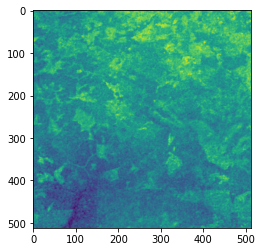

In [28]:
dataset_taken = dataset.take(1).as_numpy_iterator()
img_iterator = iter(dataset_taken)
plt.imshow(next(img_iterator))

In [34]:
def process_input(input_tensor, upscale_factor):
    shrunk = input_tensor[::, ::upscale_factor, ::upscale_factor]
    print(shrunk.shape)
    return shrunk

In [35]:
def process_target(input_tensor):
    return input_tensor

In [36]:
train_ds = train_ds.map(
    lambda x: (process_input(x, upscale_factor), process_target(x))
)
valid_ds = valid_ds.map(
    lambda x: (process_input(x, upscale_factor), process_target(x))
)

(None, 256, 256)
(None, 256, 256)


In [37]:

train_ds.reduce(0, lambda x, _: x + 1).numpy()

104

In [38]:
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [47]:
def get_model(upscale_factor=2):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, 1))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(upscale_factor ** 2, 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)
    print(outputs)

    return keras.Model(inputs, outputs)


In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


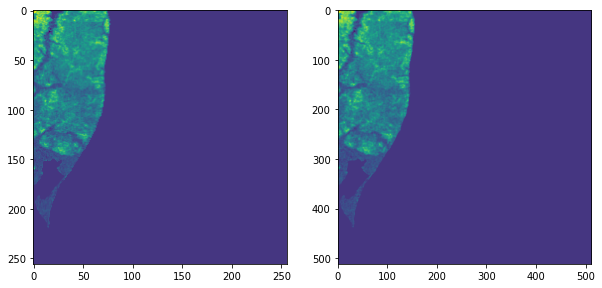

In [49]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for batch in train_ds.take(1):
    for img in batch[0]:
        ax1.imshow(img)
    for img in batch[1]:
        ax2.imshow(img)


In [50]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(files[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))

        prediction = upscale_image(self.model, self.test_img)
        plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [51]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)


KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), name='tf.nn.depth_to_space_1/DepthToSpace:0', description="created by layer 'tf.nn.depth_to_space_1'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 64)    1664      
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 4)     1156      
                                                              

In [52]:
valid_ds.element_spec

(TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None))

Epoch 1/100


2023-03-08 23:51:21.636703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 758 of 1032
2023-03-08 23:51:30.874739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-03-08 23:55:01.238352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 290 of 1032
2023-03-08 23:55:11.263116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 585 of 1032
2023-03-08 23:55:21.260626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 876 of 1032
2023-03-08 23:55:26.498946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


Mean PSNR for epoch: 33.72
1/1 [==============================] - 0s 103ms/step


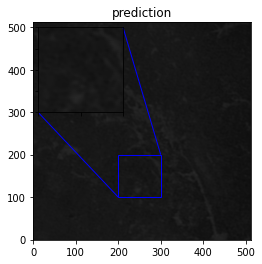

104/104 - 261s - loss: 9.5284e-05 - val_loss: 4.4729e-04 - 261s/epoch - 3s/step
Epoch 2/100


2023-03-08 23:55:42.089958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 293 of 1032
2023-03-08 23:55:44.144488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-03-08 23:58:55.378952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 291 of 1032
2023-03-08 23:59:05.395577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 577 of 1032
2023-03-08 23:59:15.673622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 824 of 1032
2023-03-08 23:59:25.489553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 850 of 1032


: 

: 

In [57]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)